# 변이형 오토인코더

In [1]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, \
                                                Conv2DTranspose, Reshape, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from IPython import display

In [2]:
BATCH_SIZE = 128
LATENT_DIM = 2

## 데이터 load

In [3]:
def map_image(image, label):
    '''주어진 이미지에서 정규화되고 재구성된 텐서를 반환합니다.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    image = tf.reshape(image, shape=(28, 28, 1,))
    return image

In [4]:
train_dataset = tfds.load('mnist', as_supervised=True, split="train")
test_dataset = tfds.load('mnist', as_supervised=True, split="test")
train_dataset, len(train_dataset), test_dataset, len(test_dataset)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 60000,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 10000)

In [5]:
train_ds = train_dataset.map(map_image).shuffle(1024).batch(BATCH_SIZE)
test_ds = test_dataset.map(map_image).shuffle(1024).batch(BATCH_SIZE)
train_ds, test_ds

(<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>,
 <_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>)

## 신경망 구조 정의

<img src="https://i.imgur.com/auIX6vL.png" WIDTH=600/>|

### Sampling Class

먼저 'Sampling' 클래스를 빌드합니다. 이것은 인코더 출력의 평균 (mu) 및 표준 편차 (sigma)와 함께 가우스 노이즈 입력을 제공하는 맞춤형 Keras 레이어입니다. 실제로 이 레이어의 출력은 다음 방정식으로 제공됩니다.

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

여기서 $\mu$ = mean, $\sigma$ = standard deviation, $\epsilon$ = random sample

In [22]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """인코더의 출력과 결합하여 무작위 샘플을 생성합니다.
        Args:
          inputs -- 인코더로부터의 출력 텐서 (평균 mu, 표준편차 sigma)
        Returns:
          무작위 샘플이 결합된 `inputs` 텐서
        """
        # 인코더의 출력을 분해합니다.
        mu, sigma = inputs

        # 배치의 크기와 차원을 얻습니다.
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # 무작위 텐서를 생성합니다.
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # 재매개변수화 기법을 적용합니다.
        return mu + tf.math.exp(0.5 * sigma) * epsilon

### Kullback–Leibler Divergence
모델의 생성 능력을 향상 시키려면 잠재 공간에 도입된 랜덤 정규 분포를 고려해야 합니다. 이를 위해 [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514)가 계산되어 재구성 손실에 추가됩니다. 공식은 아래 함수에서 정의됩니다.

In [23]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """Kullback-Leibler 발산(KLD) 계산
    Args:
    inputs -- 데이터셋 배치
    outputs -- Sampling 층의 출력
    mu -- 평균
    sigma -- 표준 편차

    Returns:
    KLD 손실
    """
    # KLD 계산 공식 적용
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    # 배치 내 평균을 계산하고 -0.5를 곱하여 최종 KLD 손실을 계산
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

### VAE Model
이제 전체 VAE 모델을 정의할 수 있습니다. KL reconstruction loss를 추가하기 위해 `model.add_loss()`를 사용합니다. 이 손실을 계산하는 것은 `y_true`와 `y_pred`를 사용하지 않으므로 `model.compile()`에서 사용할 수 없습니다.

- add_loss() 메서드 : 손실이 있는 경우, 자동으로 합산되어 주 손실에 추가

In [24]:
# 인코더의 입력 - 28x28 크기의 그레이스케일 이미지
encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, kernel_size=3, strides=1, padding = 'same', activation='leaky_relu')(encoder_inputs)
x = Conv2D(64, kernel_size=3, strides=2, padding = 'same', activation='leaky_relu')(x)
x = Conv2D(64, kernel_size=3, strides=2, padding = 'same', activation='leaky_relu')(x)
before_flatten = Conv2D(64, kernel_size=3, strides=1, padding = 'same', activation='leaky_relu')(x)
# 플랫튼 레이어를 통해 특징 맵을 1차원 벡터로 변환
x = Flatten()(before_flatten)
# Dense 레이어를 통해 특징을 20차원의 벡터로 변환
x = Dense(20, activation='relu')(x)

# 잠재 공간의 평균과 로그 분산을 나타내는 두 개의 Dense 레이어를 정의
mu = Dense(LATENT_DIM, name='mu')(x)
sigma = Dense(LATENT_DIM, name='sigma')(x)
# Sampling 레이어를 사용하여 평균과 로그 분산을 기반으로 잠재 벡터 z를 샘플링
# Sampling() 함수는 재매개변수화(reparameterization) 트릭을 구현
z = Sampling()((mu, sigma))

# 입력과 출력을 정의하여 인코더 모델을 생성합니다.
encoder = Model(encoder_inputs, outputs=[mu, sigma, z])
# 인코더 모델의 요약 정보를 출력합니다.
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 28, 28, 32)           320       ['input_3[0][0]']             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 14, 14, 64)           18496     ['conv2d_4[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 7, 7, 64)             36928     ['conv2d_5[0][0]']            
                                                                                            

In [25]:
shape = before_flatten.shape
shape

TensorShape([None, 7, 7, 64])

In [26]:
# 디코더의 입력 - 잠재 공간의 차원과 일치해야 합니다.
decoder_inputs = Input(shape=(LATENT_DIM,))
# Dense 레이어를 통해 입력을 원본 이미지의 차원으로 변환하기 위한 벡터로 확장
# shape[1] * shape[2] * shape[3]은 원본 이미지 차원을 재구성하기 위한 총 원소 수
x = Dense(shape[1] * shape[2] * shape[3])(decoder_inputs)
# Reshape 레이어를 통해 1차원 벡터를 원본 이미지의 차원과 동일한 3차원 형태로 재구성
x = Reshape((shape[1], shape[2], shape[3]))(x)
# Conv2DTranspose 레이어를 사용하여 업샘플링과 동시에 특징 맵 학습
x = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding = 'same', activation='leaky_relu')(x)
x = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding = 'same', activation='leaky_relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding = 'same', activation='leaky_relu')(x)
# 최종 Conv2DTranspose 레이어는 원본 이미지의 채널 수와 일치하는 필터 수(예: 그레이스케일 이미지의 경우 1)를 사용하며,
# sigmoid 활성화 함수를 통해 최종 이미지의 픽셀 값을 [0, 1] 범위로 조정합니다.
decoder_output = Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding = 'same', activation='sigmoid')(x)

# 입력과 출력을 정의하여 디코더 모델을 생성
decoder = Model(decoder_inputs, decoder_output)
decoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 3136)              9408      
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 7, 7, 64)          36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 28, 28, 32)        1846

In [27]:
# VAE 모델의 입력을 인코더의 입력으로 설정합니다. 이는 원본 이미지 데이터가 됩니다.
vae_inputs = encoder_inputs
# 인코더를 통과시켜 평균(mu), 표준 편차(sigma), 그리고 잠재 공간의 벡터(z)를 얻습니다.
mu, sigma, z = encoder(vae_inputs)
# 디코더를 사용하여 잠재 공간의 벡터(z)로부터 이미지를 재구성
reconstructed = decoder(z)

# 입력과 재구성된 이미지를 사용하여 VAE 모델을 생성
vae = Model(vae_inputs, reconstructed)
# Kullback-Leibler 발산을 계산하는 함수를 사용하여 손실을 추가합니다. 이는 잠재 공간의 분포가
# 우리가 원하는 분포(예: 표준 정규 분포)에 가까워지도록 돕습니다.
loss = kl_reconstruction_loss(vae_inputs, z, mu, sigma)
# add_loss는 사용자 정의 손실을 추가하는 메서드
vae.add_loss(loss)

In [28]:
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# 학습 과정에서의 평균 손실을 추적
loss_metric = tf.keras.metrics.Mean()
# 이진 교차 엔트로피 손실 함수를 사용합니다.
bce_loss = tf.keras.losses.BinaryCrossentropy()

## 오토인코더 훈련

In [29]:
def generate_and_save_images(decoder, epoch, step, test_input):
    """이미지 16개를 생성하고 저장하는 도우미 함수
    Args:
    epoch -- 학습 중인 현재 에포크 번호
    step -- 학습 중인 현재 스텝 번호
    test_input -- (16, LATENT_DIM) 모양의 임의의 텐서
    """
    # 테스트 입력에서 이미지 생성
    reconstructed = decoder(test_input)

    # 결과 플롯
    fig = plt.figure(figsize=(4, 4))

    for i in range(reconstructed.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(reconstructed[i, :, :, 0], cmap='gray')  # i번째 이미지를 회색조로 표시
        plt.axis('off')  # 축을 표시하지 않음

    fig.suptitle("epoch: {}, step: {}".format(epoch, step))  # 그림의 제목에 에포크와 스텝 표시
    plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))  # 파일로 저장
    plt.show()

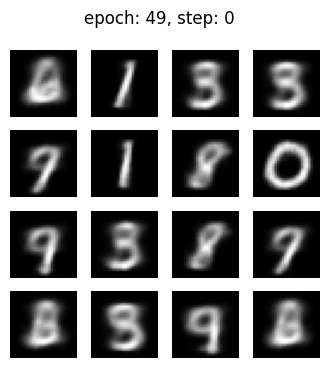

Epoch: 49 step: 0 mean loss = 180.20435


In [14]:
epochs = 50

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    for step, (x_batch_train, x_batch_test) in enumerate(zip(train_ds, test_ds)):
        with tf.GradientTape() as tape:
            # VAE 모델에 배치 입력을 공급하여 재구성된 결과를 얻음
            reconstructed = vae(x_batch_train)

            # 재구성 손실을 계산
            # 입력과 출력을 평탄화하여 이진 교차 엔트로피 손실 계산
            flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
            flattened_outputs = tf.reshape(reconstructed, shape=[-1])
            loss = bce_loss(flattened_inputs, flattened_outputs) * 784  # 28x28 이미지 크기에 해당하는 손실 확장

            # KLD 정규화 손실을 추가
            loss += sum(vae.losses)      # vae.losses에는 KLD 손실이 포함됨

        # 그라디언트를 계산하고 가중치 업데이트
        grads = tape.gradient(loss, vae.trainable_weights)
        optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        # 손실 지표 계산
        loss_metric(loss)

        # 매 100 스텝마다 결과 표시
        if step % 100 == 0:
            display.clear_output(wait=False)
            _, _, z = encoder(x_batch_test[:16])             # 테스트 배치에서 잠재 벡터 z를 얻음
            generate_and_save_images(decoder, epoch, step, z)  # 디코더를 사용해 이미지 생성 및 저장
            print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))  # 현재 에포크, 스텝, 평균 손실 출력

(128, 28, 28, 1)


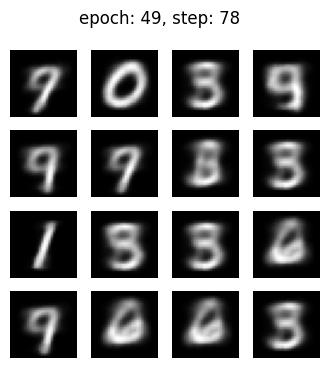

In [15]:
x_batch_test = next(iter(test_ds))  # 테스트 데이터셋에서 첫 번째 배치를 가져옴
print(x_batch_test.shape)             # 가져온 배치의 형태를 출력

_, _, z = encoder(x_batch_test[:16])  # 인코더를 사용하여 테스트 배치의 처음 16개 샘플로부터 잠재 변수 z를 생성
generate_and_save_images(decoder, epoch, step, z)  # 디코더와 z를 사용하여 이미지를 생성하고 저장하는 함수 호출

## 원본 그림 재구성

In [16]:
n_to_show = 10
example_images = x_batch_test[:n_to_show]
example_images.shape

TensorShape([10, 28, 28, 1])

In [17]:
mu, sigma, z = encoder(example_images)
reconst_images  = decoder(mu, sigma, z)

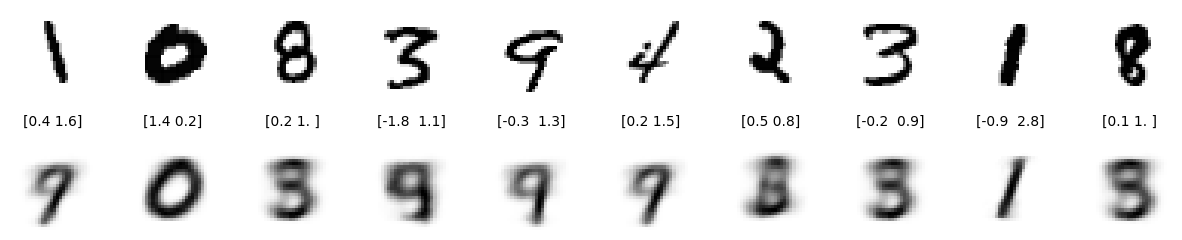

In [18]:
fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)  # 서브플롯 간의 간격 조정

for i in range(n_to_show):  # 원본 이미지 표시
    img = example_images[i].numpy().squeeze()  # 텐서를 NumPy 배열로 변환 후 차원 축소
    sub = fig.add_subplot(2, n_to_show, i+1)  # 2행 n_to_show열의 그리드에서 (i+1)번째 위치에 서브플롯 생성
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z[i],1)), fontsize=10, ha='center', transform=sub.transAxes)  # 잠재 변수 z의 값을 서브플롯 아래에 텍스트로 표시
    sub.imshow(img, cmap='gray_r')  # 이미지를 그레이스케일 반전으로 표시

for i in range(n_to_show):  # 재구성된 이미지 표시
    img = reconst_images[i].numpy().reshape(28, 28)  # 재구성된 이미지를 28x28로 재구성
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)  # 2행 n_to_show열의 그리드에서 두 번째 행의 (i+1)번째 위치에 서브플롯 생성
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')  # 이미지를 그레이스케일 반전으로 표시
